## Skorch SA network classification example

In [1]:
"""
Parts taken from - 
https://skorch.readthedocs.io/en/stable/user/tutorials.html
https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html 
""" 

In [ ]:
!pip install pyperch

In [1]:
import numpy as np
from sklearn.datasets import make_classification
import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch import NeuralNet
from pyperch.neural.sa_nn import SAModule  
from pyperch.utils.decorators import add_to
from skorch.dataset import unpack_data
import copy
import matplotlib.pyplot as plt

In [2]:
"""
To set a random seed for reproducibility, see -
https://skorch.readthedocs.io/en/stable/user/FAQ.html#how-can-i-set-the-random-seed-of-my-model

Note: algorithms and data are random.  Consider averaging results with different seeds.  
"""
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html
X, y = make_classification(1000, 12, n_informative=10, random_state=seed)
X = X.astype(np.float32)
y = y.astype(np.int64)

In [3]:
"""
Initialize the neural network.

SAModule specific parameters begin with module__

All other NeuralNetClassifier parameters, see 
https://skorch.readthedocs.io/en/stable/classifier.html 

module__layer_sizes {array-like}:
    Sizes of all layers including input, hidden, and output layers. Must be a tuple or list of integers.

module__t {int}:
    SA temperature.
    default=10000

module__cooling {float}:
    Cooling rate.
    default=.95

module__dropout_percent {float}:
    Probability of an element to be zeroed.  
    Default=0

module__step_size {float}:
    Step size for hill climbing.
    Default=.1

module__activation {torch.nn.modules.activation}:
    Activation function.  
    Default=nn.ReLU()

module__output_activation {torch.nn.modules.activation}:
    Output activation.
    Default=nn.Softmax(dim=-1)

"""

from skorch.callbacks import EpochScoring 

net = NeuralNetClassifier(
    module=SAModule,
    module__layer_sizes=(12, 32, 2),
    #module__dropout_percent=(.05),
    module__step_size=.1,
    module__t=20000,
    module__cooling=.99,
    max_epochs=5000,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [4]:
# fit data
net.fit(X, y)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SAModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=12, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=2, bias=True)
    )
  ),
)

## Plot learning curves

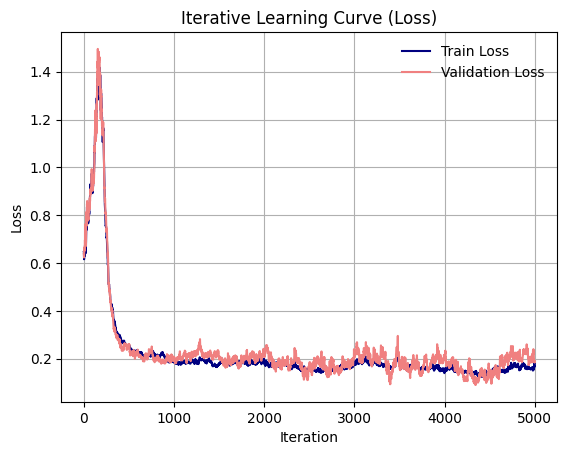

In [7]:
# plot the iterative learning curve (loss)
plt.plot(net.history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(net.history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.grid(visible=True)
plt.legend(frameon=False)

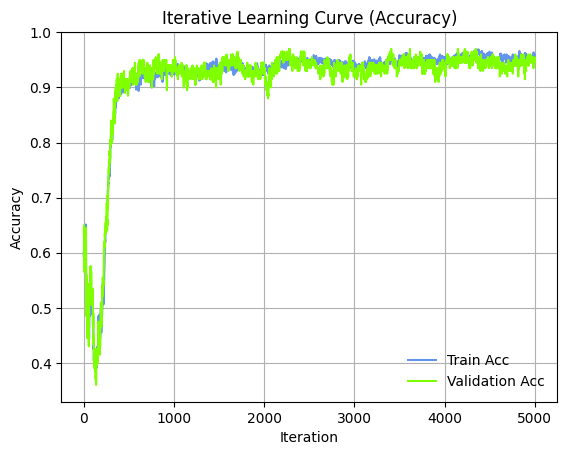

In [8]:
# plot the iterative learning curve (accuracy)
plt.plot(net.history[:, 'train_acc'], label='Train Acc', color='cornflowerblue')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy)")
plt.grid(visible=True)
plt.legend(frameon=False)

## Using sklearn learning curve with RO

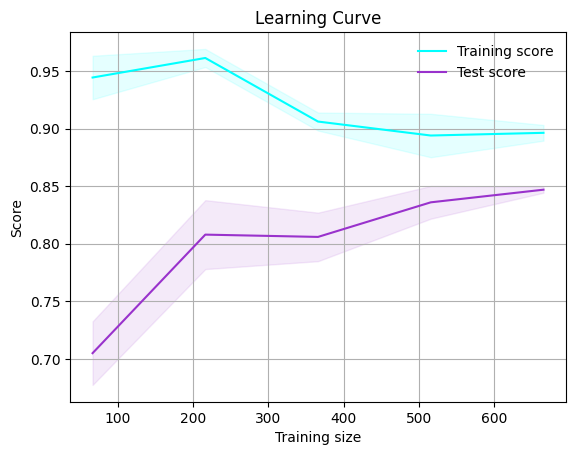

In [10]:
from sklearn.model_selection import learning_curve

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    net, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=3
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='cyan')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='darkorchid')
plt.plot(train_sizes, train_scores_mean, label="Training score", color='cyan')
plt.plot(train_sizes, test_scores_mean, label="Test score", color='darkorchid')
plt.title("Learning Curve")
plt.xlabel("Training size")
plt.ylabel("Score")
plt.grid(visible=True)
plt.legend(frameon=False)

## Using sklearn pipeline with RO

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('net', net),
])

pipe.fit(X, y)
y_proba = pipe.predict_proba(X)

## Using sklearn grid search with RO

In [9]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0, )

# module specific parameters need to begin with 'module__'
default_params = {
    'module__layer_sizes': [(12, 32, 20, 2)],
    'max_epochs': [500],
    'module__step_size': [0.1],
    'module__t': [20000],
}

grid_search_params = {
    'module__cooling': [0.97, 0.999999999],
    **default_params,
}

#change n_jobs to run jobs in parallel, see: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
gs = GridSearchCV(net, grid_search_params, n_jobs=1, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END max_epochs=500, module__cooling=0.97, module__layer_sizes=(12, 32, 20, 2), module__step_size=0.1, module__t=20000; total time=   8.1s
[CV] END max_epochs=500, module__cooling=0.97, module__layer_sizes=(12, 32, 20, 2), module__step_size=0.1, module__t=20000; total time=   9.0s
[CV] END max_epochs=500, module__cooling=0.97, module__layer_sizes=(12, 32, 20, 2), module__step_size=0.1, module__t=20000; total time=   8.7s
[CV] END max_epochs=500, module__cooling=0.999999999, module__layer_sizes=(12, 32, 20, 2), module__step_size=0.1, module__t=20000; total time=   7.8s
[CV] END max_epochs=500, module__cooling=0.999999999, module__layer_sizes=(12, 32, 20, 2), module__step_size=0.1, module__t=20000; total time=   7.4s
[CV] END max_epochs=500, module__cooling=0.999999999, module__layer_sizes=(12, 32, 20, 2), module__step_size=0.1, module__t=20000; total time=   7.4s
best score: 0.886, best params: {'max_epochs': 500, 'module__c